## Imports

In [1]:
#Base
import pandas as pd
import numpy as np

#others

import itertools
import string
import re

#Visuals
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [3]:
#nltk
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, sent_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from nltk import WordNetLemmatizer, pos_tag

### CSV File - EDA

In [4]:
#loading csv file

df = pd.read_csv('/Users/kellyjara/Desktop/Project_4/Data/judge-1377884607_tweet_product_company.csv', 
                encoding='latin-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
# Viewing columns and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
#checking NaN values in columns

df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
# Dropping column as it is not needed for sentiment analysis

df.drop(columns = 'emotion_in_tweet_is_directed_at', inplace = True)

In [8]:
# Dropping NaN values in the df
df.dropna(axis = 0, inplace = True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(2)
memory usage: 213.1+ KB


In [10]:
# Renaming column for easier callback/reference

df.rename(columns = {'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace = True)

In [11]:
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [12]:
# Dropping values that contain no emotion; Keeping only positive and negative emotions
df2 = df[df['emotion'] != "I can't tell"]
df2 = df2[df2['emotion'] != "No emotion toward brand or product"]

In [13]:
df2['emotion'].value_counts()

Positive emotion    2978
Negative emotion     570
Name: emotion, dtype: int64

In [14]:
# Creating emotion column into a numerical value
df2['target'] = df2['emotion'].astype('category')
categories = ['Positive emotion', 'Negative emotion']
df2['target'] = df2['target'].cat.reorder_categories(categories)
df2['target'] = df2['target'].cat.codes
df2['target'].value_counts()

0    2978
1     570
Name: target, dtype: int64

In [15]:
# Viewing 1st tweet in the df 
tweet_1 = df['tweet_text'].iloc[0]
tweet_1

'.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.'

<Axes: xlabel='emotion', ylabel='count'>

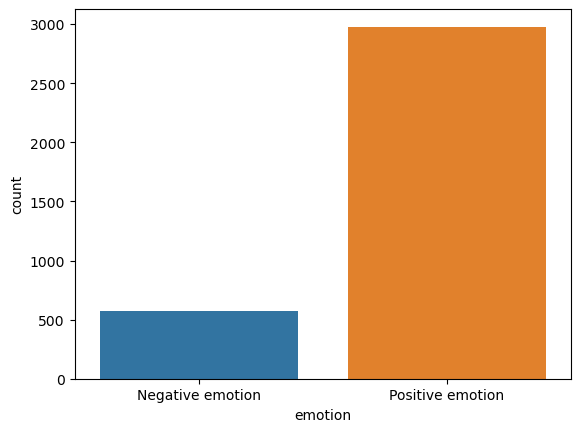

In [16]:
#Visualization of data distribution
sns.countplot(x = 'emotion', data = df2)

## Text PreProcessing 

In [17]:
def process_tweet(tweet_text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('JJ'):
            return wordnet.ADJ
        elif nltk_tag.startswith('VB'):
            return wordnet.VERB
        elif nltk_tag.startswith('NN'):
            return wordnet.NOUN
        elif nltk_tag.startswith('RB'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    tweet_lower = tweet_text.lower()

    # remove mentions, hashtags, and urls, strip whitspace and breaks
    tweet_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", 
                         tweet_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    # removing special characters 
    tweet_spec = re.sub(r"[^a-zA-Z0-9 ]", "", tweet_lower)
    
    
    # removing stop words and punctuations 
    tweet_norm = [x for x in word_tokenize(tweet_spec) if ((x.isalpha()) & (x not in stop_words)) ]
    
    # creating list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(tweet_norm))) 

    # rejoining lemmatized sentence 
    tweet_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
    return tweet_norm

In [18]:
#creating new df with normalized tweets column
df2['norm_tweet'] = df2['tweet_text'].apply(process_tweet, args = [3])
df2

,tweet_text,emotion,target,norm_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,1,iphone hr tweet dead need upgrade plugin station
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,0,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,0,wait also sale
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,1,hope year festival isnt crashy year iphone app
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,0,great stuff fri mayer google tim oreilly tech ...
...,...,...,...,...
9077,@mention your PR guy just convinced me to swit...,Positive emotion,0,pr guy convince switch back iphone great coverage
9079,&quot;papyrus...sort of like the ipad&quot; - ...,Positive emotion,0,quotpapyrussort ipadquot nice lol lavelle
9080,Diller says Google TV &quot;might be run over ...,Negative emotion,1,diller say google tv quotmight run playstation...
9085,I've always used Camera+ for my iPhone b/c it ...,Positive emotion,0,ive always use camera iphone bc image stabiliz...


In [19]:
df2.to_csv('Data/Normalized_tweets.csv') 